<a href="https://colab.research.google.com/github/claudio1975/Generative_Modelling/blob/main/Synthetic_Data_with_TCVAE_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [ ]:
! pip install shap &> /dev/null

In [ ]:
import os #  for environment operations
import random # for generating random numbers
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import tensorflow as tf # for building deep learning models
from tensorflow import keras
from keras import layers, Model
from tensorflow.keras.layers import Concatenate
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.linear_model import TweedieRegressor
import shap

In [ ]:
DEFAULT_RANDOM_SEED = 0 # Set a random seed for reproducibility throughout Python, NumPy, and TensorFlow operations
random.seed(DEFAULT_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(DEFAULT_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(DEFAULT_RANDOM_SEED)
tf.random.set_seed(DEFAULT_RANDOM_SEED)

### Upload the dataset and data handling

In [ ]:
df=pd.read_csv('/content/ausprivauto0405.csv')

In [ ]:
print(df.shape)

(67856, 9)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     67856 non-null  float64
 1   VehValue     67856 non-null  float64
 2   VehAge       67856 non-null  object 
 3   VehBody      67856 non-null  object 
 4   Gender       67856 non-null  object 
 5   DrivAge      67856 non-null  object 
 6   ClaimOcc     67856 non-null  int64  
 7   ClaimNb      67856 non-null  int64  
 8   ClaimAmount  67856 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 4.7+ MB
None


In [ ]:
print(df.columns)

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [ ]:
df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
1,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
2,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
3,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
4,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0


In [ ]:
df_duplicated_rows=df[df.duplicated()]
df_duplicated_rows

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
63,0.095825,2.650,youngest cars,Sedan,Female,working people,0,0,0.0
152,0.616016,0.450,oldest cars,Hatchback,Female,oldest people,0,0,0.0
1003,0.002738,3.170,youngest cars,Utility,Male,youngest people,0,0,0.0
1031,0.848734,4.700,youngest cars,Station wagon,Female,young people,0,0,0.0
1165,0.903491,1.280,oldest cars,Station wagon,Male,oldest people,0,0,0.0
...,...,...,...,...,...,...,...,...,...
67769,0.251882,0.980,old cars,Sedan,Female,old people,0,0,0.0
67779,0.851472,5.236,youngest cars,Station wagon,Female,older work. people,0,0,0.0
67796,0.908966,2.440,youngest cars,Sedan,Female,old people,0,0,0.0
67811,0.769336,1.200,old cars,Sedan,Male,youngest people,0,0,0.0


In [ ]:
df=df.drop_duplicates()

In [ ]:
df_duplicated_col=df.columns[df.columns.duplicated()]
df_duplicated_col

Index([], dtype='object')

In [ ]:
missing=df.isnull().sum()/df.shape[0]*100
missing

,0
Exposure,0.0
VehValue,0.0
VehAge,0.0
VehBody,0.0
Gender,0.0
DrivAge,0.0
ClaimOcc,0.0
ClaimNb,0.0
ClaimAmount,0.0


### Encoding

In [ ]:
print(df['VehAge'].unique())
print(df['DrivAge'].unique())
print(df['VehBody'].unique())
print(df['Gender'].unique())


['old cars' 'young cars' 'oldest cars' 'youngest cars']
['young people' 'older work. people' 'oldest people' 'working people'
 'old people' 'youngest people']
['Hatchback' 'Utility' 'Station wagon' 'Hardtop' 'Panel van' 'Sedan'
 'Truck' 'Coupe' 'Minibus' 'Motorized caravan' 'Bus' 'Convertible'
 'Roadster']
['Female' 'Male']


In [ ]:
df_encod=df.copy()
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df_encod['VehAge'] = df_encod['VehAge'].map(VehAge_group)
df_encod['VehAge']= df_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df_encod['DrivAge'] = df_encod['DrivAge'].map(DrivAge_group)
df_encod['DrivAge']= df_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df_encod['VehBody'] = df_encod['VehBody'].map(VehBody_group)
df_encod['VehBody']= df_encod['VehBody'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df_encod['Gender'] = df_encod['Gender'].map(Gender_group)
df_encod['Gender']= df_encod['Gender'].astype(int)




In [ ]:
df_encod.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,1,1,0,1,0,0,0.0
1,0.648871,1.03,2,1,0,2,0,0,0.0
2,0.569473,3.26,2,2,0,1,0,0,0.0
3,0.317591,4.14,2,3,0,1,0,0,0.0
4,0.648871,0.72,3,1,0,1,0,0,0.0


### Split dataset

In [ ]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df_encod, test_size=0.2, random_state=0)

In [ ]:
X_train.shape

(53320, 9)

### Build a CTVAE

In [ ]:
#----------------------
# Setting Random Seeds
#----------------------
np.random.seed(0)
tf.random.set_seed(0)

# ---------------------------------------------------
# Define Transformer Components
# ---------------------------------------------------

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training, mask=None):
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection + LayerNorm
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual connection + LayerNorm


#-----------------------------------
# Column Definitions and Validation
#-----------------------------------
condition_col = 'ClaimOcc'          # Binary condition
target_discrete = 'ClaimNb'         # Discrete variable
target_continuous = 'ClaimAmount'   # Continuous variable

#------------------------------------
#Feature Selection and Normalization
#------------------------------------
# Define features to include
features = [col for col in X_train.columns if col != condition_col]

# Extract features and condition
X_features = X_train[features].values
X_condition = X_train[condition_col].values.reshape(-1, 1)

# Normalize all features
means = np.mean(X_features, axis=0)
stds = np.std(X_features, axis=0)
# To avoid division by zero
stds_corrected = np.where(stds == 0, 1, stds)
X_features_normalized = (X_features - means) / stds_corrected

# Prepare the input for the CVAE (features + condition)
X_input = np.concatenate([X_features_normalized, X_condition], axis=1)

# ---------------------------------------------------
# Build the CVAE with Transformer Decoder
# ---------------------------------------------------

# Define dimensions
input_dim = X_input.shape[1]        # Number of features + condition
latent_dim = 5                      # Dimension of latent space
condition_dim = 1                   # Since ClaimOcc is binary
embed_dim = 32                      # Embedding dimension for Transformer
num_heads = 4                       # Number of attention heads
ff_dim = 64                         # Feed-Forward Network dimension
num_transformer_blocks = 2         # Number of Transformer blocks

# Encoder
encoder_inputs = layers.Input(shape=(input_dim,), name='encoder_input')
encoder_hidden = layers.Dense(32, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(encoder_hidden)

# Sampling layer using reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(z_log_var * 0.5) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
# Concatenate latent vector with condition
decoder_inputs = layers.Concatenate(name='decoder_input')([z, encoder_inputs[:, -condition_dim:]])

# Project to embedding dimension and reshape for Transformer
# Here, we treat [z, condition] as a sequence of 2 tokens
decoder_embedding = layers.Dense(embed_dim, activation='relu')(decoder_inputs)  # Shape: (batch_size, embed_dim)

# Reshape to (batch_size, sequence_length, embed_dim_per_token)
# Let's define sequence_length=2 (z and condition)
sequence_length = 2
embed_dim_per_token = embed_dim // sequence_length
decoder_reshape = layers.Reshape((sequence_length, embed_dim_per_token))(decoder_embedding)

# Apply Transformer Blocks
x = decoder_reshape
for _ in range(num_transformer_blocks):
    transformer_block_instance = TransformerBlock(embed_dim=embed_dim_per_token,
                                                  num_heads=num_heads,
                                                  ff_dim=ff_dim)
    x = transformer_block_instance(x, training=True)

# Flatten the output of Transformer
x = layers.Flatten()(x)

# Final Dense layers to reconstruct the input features
decoder_hidden = layers.Dense(32, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim - condition_dim, activation='linear')(decoder_hidden)

# Define the encoder and decoder models
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

#-----------------------------------
# Defining the Custom Loss Function
#-----------------------------------
def vae_loss(x, x_decoded, z_mean, z_log_var, condition):
    """
    Computes the VAE loss including reconstruction loss, penalty terms, and KL divergence.

    Parameters:
    - x: Original input
    - x_decoded: Reconstructed input
    - z_mean: Mean of latent distribution
    - z_log_var: Log variance of latent distribution
    - condition: Condition variable (ClaimOcc)

    Returns:
    - Total loss
    """
    # Separate the inputs
    x_features = x[:, :-condition_dim]
    # x_condition = x[:, -condition_dim:]  # Not used directly in loss

    # Reconstruction loss for all features (Mean Squared Error)
    reconstruction_loss_features = tf.reduce_mean(tf.reduce_sum(tf.square(x_features - x_decoded), axis=1))

    # Find the index of 'ClaimAmount' and 'ClaimNb' in features
    try:
        claim_amount_idx = features.index(target_continuous)
        claim_nb_idx = features.index(target_discrete)
    except ValueError as e:
        raise ValueError(f"Error locating 'ClaimAmount' or 'ClaimNb' in features: {e}")

    # Extract 'ClaimAmount' and 'ClaimNb' from original and reconstructed features
    x_claim_amount = x_features[:, claim_amount_idx:claim_amount_idx + 1]
    x_decoded_claim_amount = x_decoded[:, claim_amount_idx:claim_amount_idx + 1]

    x_claim_nb = x_features[:, claim_nb_idx:claim_nb_idx + 1]
    x_decoded_claim_nb = x_decoded[:, claim_nb_idx:claim_nb_idx + 1]

    # Since 'ClaimNb' is now normalized, apply Mean Squared Error as reconstruction loss
    reconstruction_loss_claim_nb = tf.reduce_mean(
        tf.reduce_sum(tf.square(x_claim_nb - x_decoded_claim_nb), axis=1)
    )

    # Reconstruction loss for 'ClaimAmount' (Mean Squared Error)
    reconstruction_loss_claim_amount = tf.reduce_mean(
        tf.reduce_sum(tf.square(x_claim_amount - x_decoded_claim_amount), axis=1)
    )

    # Penalty terms to enforce conditional constraints based on ClaimOcc
    # When ClaimOcc=0, enforce ClaimNb=0 and ClaimAmount=0
    penalty_claim_nb_occ = tf.reduce_mean(tf.square(x_decoded_claim_nb * condition))
    penalty_claim_amount_occ = tf.reduce_mean(tf.square(x_decoded_claim_amount * condition))

    # Additional Penalty terms to enforce constraints between ClaimNb and ClaimAmount
    # When original ClaimNb = 0, enforce reconstructed ClaimAmount = 0
    # When original ClaimNb > 0, enforce reconstructed ClaimAmount > 0 (e.g., ClaimAmount >= epsilon)
    epsilon = 1e-3  # Small value to enforce ClaimAmount > 0

    # Create masks based on original ClaimNb
    mask_nb_zero = tf.cast(tf.equal(x_claim_nb, 0.0), tf.float32)
    mask_nb_positive = 1.0 - mask_nb_zero

    # Penalty when ClaimNb = 0 but reconstructed ClaimAmount != 0
    penalty_claim_amount_nb_zero = tf.reduce_mean(tf.square(x_decoded_claim_amount * mask_nb_zero))

    # Penalty when ClaimNb > 0 but reconstructed ClaimAmount <= 0
    # Since ClaimAmount is reconstructed as continuous, encourage it to be >= epsilon
    # Use ReLU to compute max(0, epsilon - ClaimAmount)
    penalty_claim_amount_nb_positive = tf.reduce_mean(
        tf.square(tf.nn.relu(epsilon - x_decoded_claim_amount) * mask_nb_positive)
    )

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )

    # Total loss with all penalties
    total_loss = (
        reconstruction_loss_features
        + reconstruction_loss_claim_amount
        + reconstruction_loss_claim_nb
        + penalty_claim_nb_occ
        + penalty_claim_amount_occ
        + penalty_claim_amount_nb_zero
        + penalty_claim_amount_nb_positive
        + kl_loss
    )
    return total_loss
#--------------------------------------
# Defining the Custom CVAE Model Class
#--------------------------------------
# Custom CVAE model with the Transformer-based decoder
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        x = data  # x includes features and condition
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            # Concatenate z with condition
            condition = x[:, -condition_dim:]
            decoder_input = tf.concat([z, condition], axis=1)
            x_decoded = self.decoder(decoder_input)
            # Compute loss
            loss = vae_loss(x, x_decoded, z_mean, z_log_var, condition)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Optionally, track metrics
        return {"loss": loss}

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        condition = inputs[:, -condition_dim:]
        decoder_input = tf.concat([z, condition], axis=1)
        return self.decoder(decoder_input)

#------------------------
# Compile and training the CVAE model
#------------------------
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer='adam')

# Verify the shape of X_input
print(f"Shape of X_input: {X_input.shape}")

# Model training
cvae.fit(X_input, epochs=50, batch_size=256, verbose=1)



Shape of X_input: (53320, 9)
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 88.4812
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 17.6267
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 10.5662
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.1498
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 8.4872
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.9354
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.6060
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.4155
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.2150
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.1145
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.0172
Epoch 12/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.9408
Epoch 13/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.8450
Epoch 14/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.8007
Epoch 15/5

### Generate Samples

In [ ]:
# ---------------------------------------------------
# Generation of Synthetic Data
# ---------------------------------------------------

# Define generation parameters
num_samples = 53320
latent_dim = 5  # Ensure consistency with the CVAE's latent dimension
condition_dim = 1  # For ClaimOcc

# Define feature names and normalization parameters
feature_names = features  # Defined based on your feature selection
mean_values = means       # NumPy array corresponding to 'features'
std_values = stds         # NumPy array corresponding to 'features'

# Verify alignment
assert len(feature_names) == len(mean_values) == len(std_values), "Feature names and normalization parameters must align."

# ---------------------------------------------------
# Generate Samples
# ---------------------------------------------------

# Define a function to generate synthetic data based on ClaimOcc
def generate_synthetic_data(num_samples, claim_occ_value=0):
    """
    Generate synthetic data with specified ClaimOcc value.

    Parameters:
    - num_samples: Number of samples to generate
    - claim_occ_value: 0 or 1

    Returns:
    - DataFrame containing generated synthetic data
    """
    # Sample latent vectors
    latent_samples = np.random.normal(size=(num_samples, latent_dim))

    # Define conditions
    condition = np.full((num_samples, condition_dim), claim_occ_value)

    # Concatenate z and condition
    decoder_input = np.concatenate([latent_samples, condition], axis=1)

    # Generate normalized samples using the decoder
    new_samples_normalized = cvae.decoder.predict(decoder_input)

    # Rescale to original feature scale
    new_samples = new_samples_normalized * std_values + mean_values

    # Convert to DataFrame
    generated_data = pd.DataFrame(new_samples, columns=feature_names)
    generated_data[condition_col] = condition.flatten()

    # Handle discrete variables
    # For 'ClaimNb', assuming it's index in features
    claim_nb_idx = feature_names.index(target_discrete)
    generated_data.iloc[:, claim_nb_idx] = np.round(generated_data.iloc[:, claim_nb_idx]).astype(int)

    # Handle 'ClaimAmount' based on 'ClaimNb'
    claim_amount_idx = feature_names.index(target_continuous)
    generated_claim_nb = generated_data.iloc[:, claim_nb_idx].values
    generated_data.iloc[:, claim_amount_idx] = np.where(
        generated_claim_nb == 0, 0, generated_data.iloc[:, claim_amount_idx]
    )

    # Enforce ClaimAmount > 0 when ClaimNb > 0 with a lower level by the mean ClaimAmount
    claim_av = X_train['ClaimAmount'].mean()
    generated_data.iloc[:, claim_amount_idx] = np.where(
        generated_claim_nb > 0,
        generated_data.iloc[:, claim_amount_idx].clip(lower=claim_av),
        generated_data.iloc[:, claim_amount_idx]
    )

    # ---------------------------------------------------
    # Post-processing: Round Specific Columns and Clip Negative Values
    # ---------------------------------------------------
    columns_to_round = ['VehAge', 'DrivAge', 'VehBody', 'Gender']

    # Round the specified columns to nearest integer
    for col in columns_to_round:
        if col in generated_data.columns:
            generated_data[col] = generated_data[col].round().astype(int)

    # Replace negative values with zero for all numerical columns
    generated_data = generated_data.clip(lower=0)

    # Handle Exposure
    if 'Exposure' in generated_data.columns:
        exposure_av = X_train['Exposure'].mean()
        generated_data.loc[generated_data['Exposure'] == 0, 'Exposure'] = exposure_av

    return generated_data

# Generate samples with ClaimOcc=0
num_samples_claim0 = 49617
synthetic_data_claim0 = generate_synthetic_data(num_samples_claim0, claim_occ_value=0)

# Generate samples with ClaimOcc=1
num_samples_claim1 = num_samples - num_samples_claim0
synthetic_data_claim1 = generate_synthetic_data(num_samples_claim1, claim_occ_value=1)

# Combine the datasets
synthetic_data = pd.concat([synthetic_data_claim0, synthetic_data_claim1], ignore_index=True)

# Shuffle the dataset to mix ClaimOcc=0 and ClaimOcc=1 samples
synthetic_data = synthetic_data.sample(frac=1, random_state=0).reset_index(drop=True)

# ---------------------------------------------------



1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
new_samples_df=synthetic_data.copy()

### Data Comparison

In [ ]:
X_train.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
16112,0.621492,1.66,1,1,0,5,0,0,0.0
39849,0.676249,0.70,3,3,0,1,0,0,0.0
41557,0.257358,2.49,1,3,0,3,0,0,0.0
59930,0.654346,0.86,1,2,1,4,0,0,0.0
60224,0.637919,2.72,2,2,1,1,0,0,0.0


In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.466535,0.288448,0.002738,0.21629,0.443532,0.706366,0.999316
VehValue,53320.0,1.784108,1.217545,0.000000,1.01000,1.500000,2.160000,34.560000
VehAge,53320.0,2.346755,1.085962,1.000000,1.00000,2.000000,3.000000,4.000000
VehBody,53320.0,3.672824,2.260395,1.000000,1.00000,3.000000,6.000000,13.000000
Gender,53320.0,0.431152,0.495242,0.000000,0.00000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.193323,1.610507,1.000000,2.00000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.00000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.074194,0.280946,0.000000,0.00000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,1004.945014,0.000000,0.00000,0.000000,0.000000,46868.179932


In [ ]:
new_samples_df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimNb,ClaimAmount,ClaimOcc
0,0.571123,2.118479,3,2,0,3,1.0,3381.11161,1
1,0.280588,2.798645,3,3,1,2,0.0,0.00000,0
2,0.563042,1.278883,2,1,0,3,0.0,0.00000,0
3,0.397913,1.487276,2,6,0,3,0.0,0.00000,0
4,0.178192,1.454276,3,2,0,1,0.0,0.00000,0


In [ ]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.446692,0.201495,0.110407,0.269644,0.425092,0.598584,1.074786
VehValue,53320.0,1.883968,0.790513,0.400405,1.513613,1.626764,1.800924,11.861329
VehAge,53320.0,2.307314,0.934775,1.000000,2.000000,2.000000,3.000000,4.000000
VehBody,53320.0,3.616185,1.719516,0.000000,2.000000,4.000000,5.000000,13.000000
Gender,53320.0,0.419430,0.493470,0.000000,0.000000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.173781,1.221104,0.000000,2.000000,3.000000,4.000000,6.000000
ClaimNb,53320.0,0.069655,0.255376,0.000000,0.000000,0.000000,0.000000,2.000000
ClaimAmount,53320.0,88.998483,532.130964,0.000000,0.000000,0.000000,0.000000,13600.331970
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [ ]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [ ]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 0
Empty DataFrame
Columns: [Exposure, VehValue, VehAge, VehBody, Gender, DrivAge, ClaimNb, ClaimAmount, ClaimOcc]
Index: []


### Visual Comparison

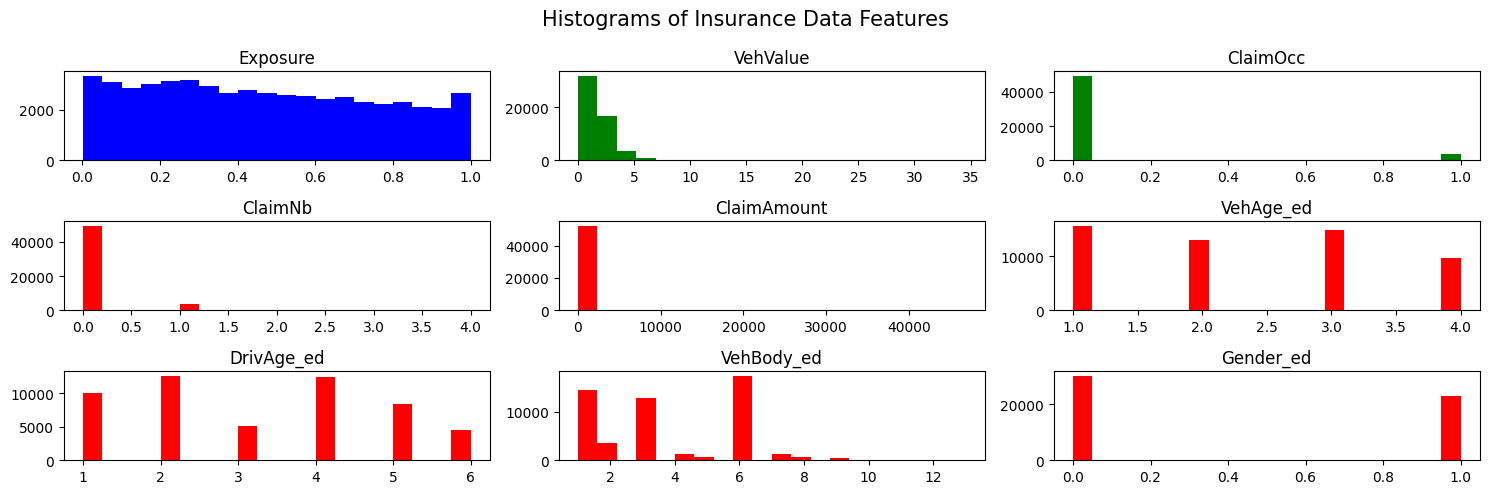

In [ ]:
# Plot histograms of the original features for visualization
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = subplots(nrows=3,ncols=3)

ax[0,0].hist(X_train['Exposure'], bins=20, color='blue')
ax[0,0].set_title('Exposure')

ax[0,1].hist(X_train['VehValue'], bins=20, color='green')
ax[0,1].set_title('VehValue')

ax[0,2].hist(X_train['ClaimOcc'], bins=20, color='green')
ax[0,2].set_title('ClaimOcc')

ax[1,0].hist(X_train['ClaimNb'], bins=20, color='red')
ax[1,0].set_title('ClaimNb')

ax[1,1].hist(X_train['ClaimAmount'], bins=20, color='red')
ax[1,1].set_title('ClaimAmount')

ax[1,2].hist(X_train['VehAge'], bins=20, color='red')
ax[1,2].set_title('VehAge_ed')

ax[2,0].hist(X_train['DrivAge'], bins=20, color='red')
ax[2,0].set_title('DrivAge_ed')

ax[2,1].hist(X_train['VehBody'], bins=20, color='red')
ax[2,1].set_title('VehBody_ed')

ax[2,2].hist(X_train['Gender'], bins=20, color='red')
ax[2,2].set_title('Gender_ed')


plt.suptitle('Histograms of Insurance Data Features', fontsize=15)
plt.tight_layout()
plt.show()

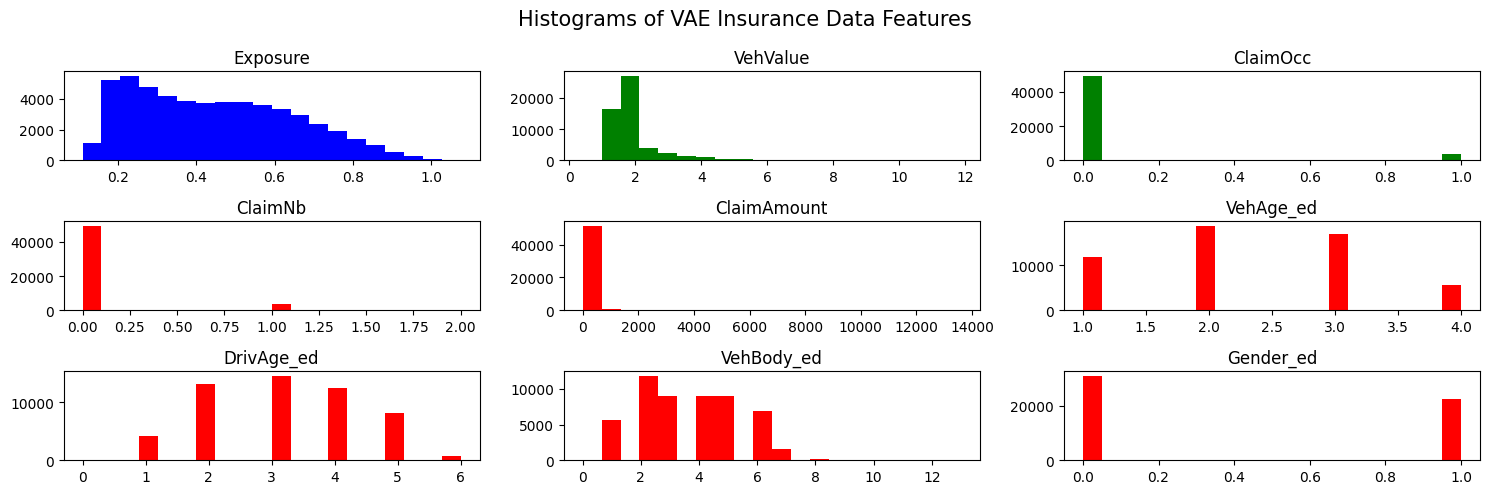

In [ ]:
# Plot histograms of the original features for visualization
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = subplots(nrows=3,ncols=3)

ax[0,0].hist(new_samples_df['Exposure'], bins=20, color='blue')
ax[0,0].set_title('Exposure')

ax[0,1].hist(new_samples_df['VehValue'], bins=20, color='green')
ax[0,1].set_title('VehValue')

ax[0,2].hist(new_samples_df['ClaimOcc'], bins=20, color='green')
ax[0,2].set_title('ClaimOcc')

ax[1,0].hist(new_samples_df['ClaimNb'], bins=20, color='red')
ax[1,0].set_title('ClaimNb')

ax[1,1].hist(new_samples_df['ClaimAmount'], bins=20, color='red')
ax[1,1].set_title('ClaimAmount')

ax[1,2].hist(new_samples_df['VehAge'], bins=20, color='red')
ax[1,2].set_title('VehAge_ed')

ax[2,0].hist(new_samples_df['DrivAge'], bins=20, color='red')
ax[2,0].set_title('DrivAge_ed')

ax[2,1].hist(new_samples_df['VehBody'], bins=20, color='red')
ax[2,1].set_title('VehBody_ed')

ax[2,2].hist(new_samples_df['Gender'], bins=20, color='red')
ax[2,2].set_title('Gender_ed')


plt.suptitle('Histograms of VAE Insurance Data Features', fontsize=15)
plt.tight_layout()
plt.show()

### Statistical Analysis

In [ ]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for Exposure: Statistic=0.16279069767441862, P-value=0.0
KS Test for VehValue: Statistic=0.3504688672168042, P-value=0.0
KS Test for VehAge: Statistic=0.07394973743435862, P-value=3.112140522269099e-127
KS Test for VehBody: Statistic=0.2142160540135033, P-value=0.0
KS Test for Gender: Statistic=0.011721680420105018, P-value=0.001305876943092647
KS Test for DrivAge: Statistic=0.10954613653413353, P-value=4.3497166687227446e-279
KS Test for ClaimOcc: Statistic=0.0, P-value=1.0
KS Test for ClaimNb: Statistic=0.004201050262565675, P-value=0.7328188239690078
KS Test for ClaimAmount: Statistic=0.008383345836459055, P-value=0.046895311350408586


### PCA Analysis

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_sc = scaler.fit_transform(X_train)
pca_train = PCA(n_components=3).fit_transform(X_train_sc)


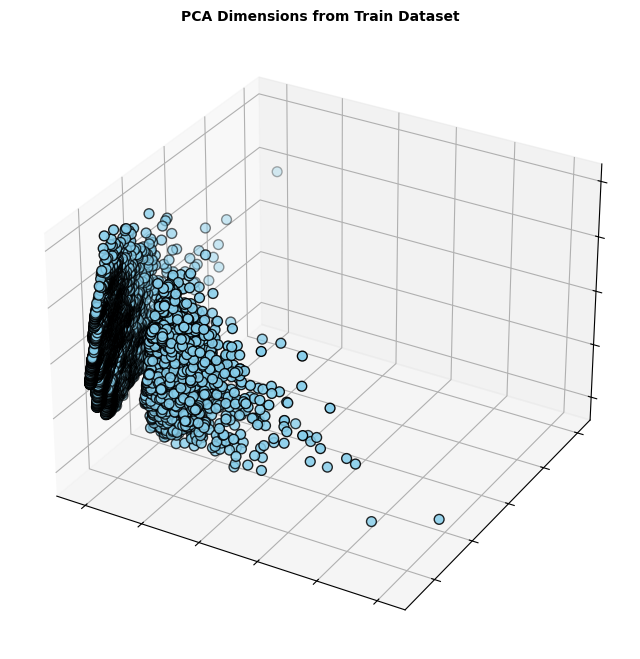

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    pca_train[:, 0],  # 1st principal component
    pca_train[:, 1],  # 2nd principal component
    pca_train[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("PCA Dimensions from Train Dataset", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

In [ ]:
new_samples_sc = scaler.fit_transform(new_samples_df)
pca_new_samples = PCA(n_components=3).fit_transform(new_samples_sc)


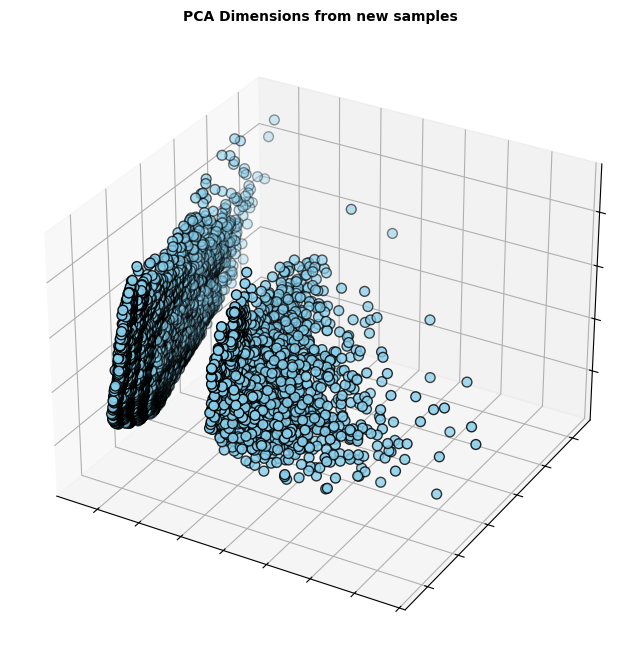

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    pca_new_samples[:, 0],  # 1st principal component
    pca_new_samples[:, 1],  # 2nd principal component
    pca_new_samples[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("PCA Dimensions from new samples", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

### UMAP Analysis

In [ ]:
umap_train = umap.UMAP(n_components=3).fit_transform(X_train_sc)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


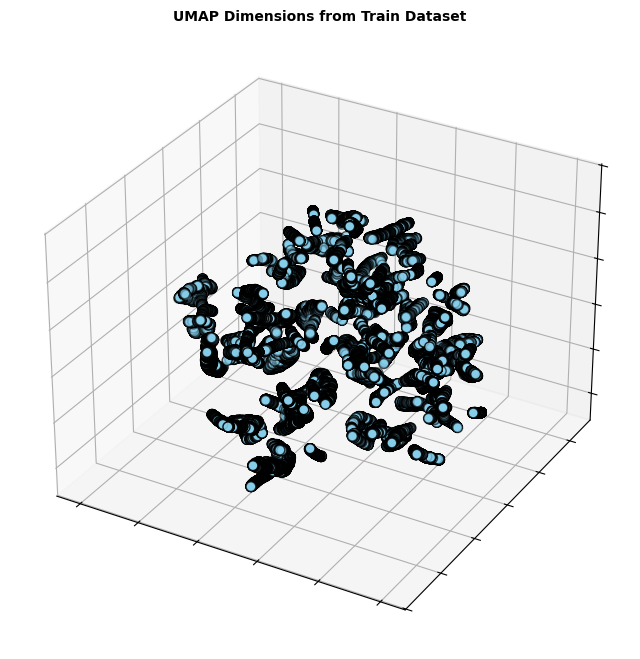

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    umap_train[:, 0],  # 1st principal component
    umap_train[:, 1],  # 2nd principal component
    umap_train[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("UMAP Dimensions from Train Dataset", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

In [ ]:
umap_new_samples = umap.UMAP(n_components=3).fit_transform(new_samples_sc)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


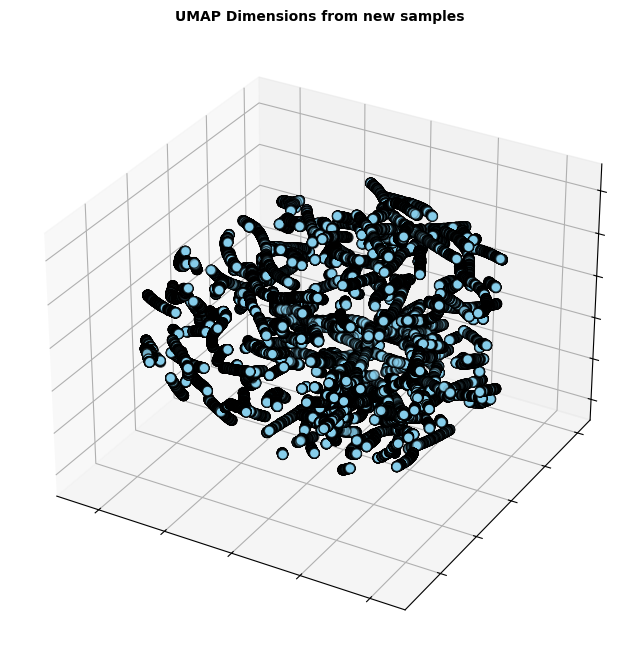

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    umap_new_samples[:, 0],  # 1st principal component
    umap_new_samples[:, 1],  # 2nd principal component
    umap_new_samples[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("UMAP Dimensions from new samples", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

### GLM Frequency Analysis

In [ ]:
X_train_freq=X_train.copy()
X_test_freq=X_test.copy()

exposure_tr_freq=X_train_freq['Exposure']
y_train_nb=X_train_freq['ClaimNb']
exposure_te_freq=X_test_freq['Exposure']
y_test_nb=X_test_freq['ClaimNb']
X_train_freq_=X_train_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_freq_=X_test_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_nb=TweedieRegressor(power=1, link='log')
glm_nb.fit(X_train_freq_, y_train_nb/exposure_tr_freq, sample_weight=exposure_tr_freq)

TweedieRegressor(link='log', power=1)

In [ ]:
glm_nb_pred_tr = glm_nb.predict(X_train_freq_)
glm_nb_pred_te = glm_nb.predict(X_test_freq_)
mpd_train_1 = mean_poisson_deviance(y_train_nb/exposure_tr_freq, glm_nb_pred_tr)
mpd_test_1 = mean_poisson_deviance(y_test_nb/exposure_te_freq, glm_nb_pred_te)

In [ ]:
mpd_train_1

1.4344568519034897

In [ ]:
mpd_test_1

1.741190103494106

In [ ]:
X_train_sample_freq=new_samples_df.copy()
X_test_sample_freq=X_test.copy()

exposure_sample_tr_freq=X_train_sample_freq['Exposure']
y_train_sample_nb=X_train_sample_freq['ClaimNb']
exposure_sample_te_freq=X_test_sample_freq['Exposure']
y_test_sample_nb=X_test_sample_freq['ClaimNb']
X_train_sample_freq_=X_train_sample_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_sample_freq_=X_test_sample_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_sample_nb=TweedieRegressor(power=1, link='log')
glm_sample_nb.fit(X_train_sample_freq_, y_train_sample_nb/exposure_sample_tr_freq, sample_weight=exposure_sample_tr_freq)

TweedieRegressor(link='log', power=1)

In [ ]:
glm_sample_nb_pred_tr = glm_sample_nb.predict(X_train_sample_freq_)
glm_sample_nb_pred_te = glm_sample_nb.predict(X_test_sample_freq_)
mpd_train_2 = mean_poisson_deviance(y_train_sample_nb/exposure_sample_tr_freq, glm_sample_nb_pred_tr)
mpd_test_2 = mean_poisson_deviance(y_test_sample_nb/exposure_sample_te_freq, glm_sample_nb_pred_te)

In [ ]:
mpd_train_2

0.6034233351009185

In [ ]:
mpd_test_2

1.7454603181727977

### GLM Cost Analysis

In [ ]:
X_train_co=X_train.copy()
X_test_co=X_test.copy()

X_train_co['Acost'] = np.where(X_train_co['ClaimNb'] != 0, X_train_co['ClaimAmount'] / X_train_co['ClaimNb'], 0)
X_test_co['Acost'] = np.where(X_test_co['ClaimNb'] != 0, X_test_co['ClaimAmount'] / X_test_co['ClaimNb'], 0)

L1 = X_train_co["ClaimAmount"] != 0
X_train_cost = X_train_co[L1]
L2 = X_test_co["ClaimAmount"] != 0
X_test_cost = X_test_co[L2]

exposure_tr_cost=X_train_cost['Exposure']
claim_tr=X_train_cost['ClaimNb']
y_train_cl=X_train_cost['Acost']
exposure_te_cost=X_test_cost['Exposure']
claim_te=X_test_cost['ClaimNb']
y_test_cl=X_test_cost['Acost']
X_train_cost_=X_train_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_cost_=X_test_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_cl=TweedieRegressor(power=2, link='log')
glm_cl.fit(X_train_cost_, y_train_cl, sample_weight=claim_tr)

TweedieRegressor(link='log', power=2)

In [ ]:
glm_cl_pred_tr = glm_cl.predict(X_train_cost_)
glm_cl_pred_te = glm_cl.predict(X_test_cost_)
mgd_train_1 = mean_gamma_deviance(y_train_cl, glm_cl_pred_tr)
mgd_test_1 = mean_gamma_deviance(y_test_cl, glm_cl_pred_te)

In [ ]:
mgd_train_1

1.5508741472884895

In [ ]:
mgd_test_1

1.7221300040077396

In [ ]:
X_sample_train_co=new_samples_df.copy()
X_sample_test_co=X_test.copy()

X_sample_train_co['Acost'] = np.where(X_sample_train_co['ClaimNb'] != 0, X_sample_train_co['ClaimAmount'] / X_sample_train_co['ClaimNb'], 0)
X_sample_test_co['Acost'] = np.where(X_sample_test_co['ClaimNb'] != 0, X_sample_test_co['ClaimAmount'] / X_sample_test_co['ClaimNb'], 0)

L1 = X_sample_train_co["ClaimAmount"] != 0
X_sample_train_cost = X_sample_train_co[L1]
L2 = X_sample_test_co["ClaimAmount"] != 0
X_sample_test_cost = X_sample_test_co[L2]

exposure_tr_sample_cost=X_sample_train_cost['Exposure']
claim_sample_tr=X_sample_train_cost['ClaimNb']
y_sample_train_cl=X_sample_train_cost['Acost']
exposure_te_sample_cost=X_sample_test_cost['Exposure']
claim_sample_te=X_sample_test_cost['ClaimNb']
y_sample_test_cl=X_sample_test_cost['Acost']
X_sample_train_cost_=X_sample_train_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)
X_sample_test_cost_=X_sample_test_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_sample_cl=TweedieRegressor(power=2, link='log')
glm_sample_cl.fit(X_sample_train_cost_, y_sample_train_cl, sample_weight=claim_sample_tr)

TweedieRegressor(link='log', power=2)

In [ ]:
glm_sample_cl_pred_tr = glm_sample_cl.predict(X_sample_train_cost_)
glm_sample_cl_pred_te = glm_sample_cl.predict(X_sample_test_cost_)
mgd_sample_train_2 = mean_gamma_deviance(y_sample_train_cl, glm_sample_cl_pred_tr)
mgd_sample_test_2 = mean_gamma_deviance(y_sample_test_cl, glm_sample_cl_pred_te)

In [ ]:
mgd_sample_train_2

1.0323081514158476

In [ ]:
mgd_sample_test_2

2.056984193334359

### Feature Importance Analysis

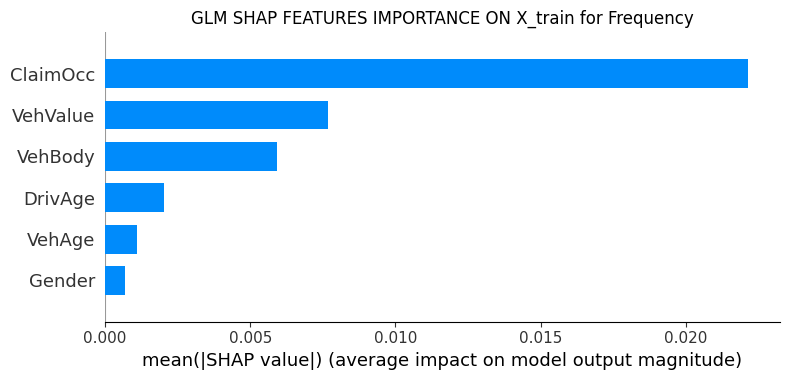

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_freq = TweedieRegressor(power=1,link='log').fit(X_train_freq_, y_train_nb/exposure_tr_freq, sample_weight=exposure_tr_freq)
masker = shap.maskers.Independent(X_train_freq_)
GLM_explainer = shap.LinearExplainer(GLM_freq, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_freq_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON X_train for Frequency")
shap.summary_plot(GLM_shap_values, features=X_test_freq_, feature_names=X_test_freq_.columns,plot_type='bar',max_display=10)

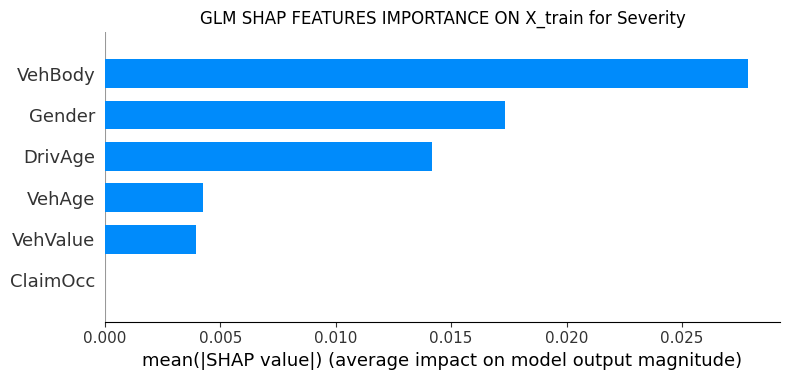

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_cost = TweedieRegressor(power=2,link='log').fit(X_train_cost_, y_train_cl, sample_weight=claim_tr)
masker = shap.maskers.Independent(X_train_cost_)
GLM_explainer = shap.LinearExplainer(GLM_cost, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_cost_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON X_train for Severity")
shap.summary_plot(GLM_shap_values, features=X_test_cost_, feature_names=X_test_cost_.columns,plot_type='bar',max_display=10)

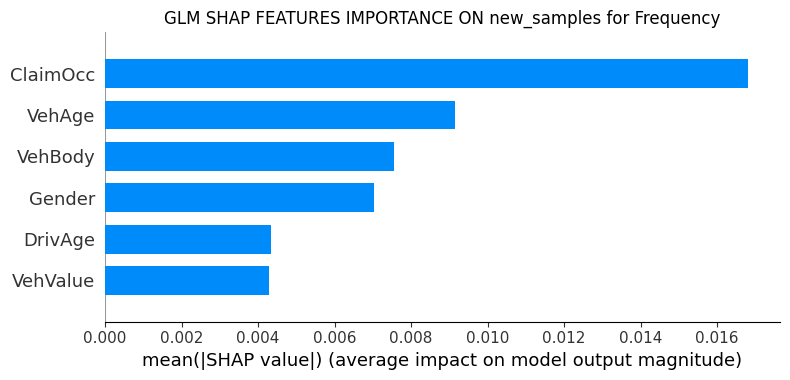

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_sample_freq = TweedieRegressor(power=1,link='log').fit(X_train_sample_freq_, y_train_sample_nb/exposure_sample_tr_freq, sample_weight=exposure_sample_tr_freq)
masker = shap.maskers.Independent(X_train_sample_freq_)
GLM_explainer = shap.LinearExplainer(GLM_sample_freq, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_sample_freq_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON new_samples for Frequency")
shap.summary_plot(GLM_shap_values, features=X_test_sample_freq_, feature_names=X_test_sample_freq_.columns,plot_type='bar',max_display=10)

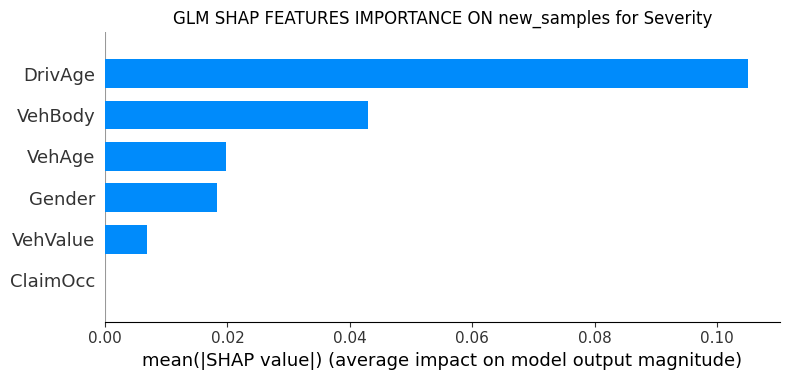

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_sample_cost = TweedieRegressor(power=2,link='log').fit(X_sample_train_cost_, y_sample_train_cl, sample_weight=claim_sample_tr)
masker = shap.maskers.Independent(X_sample_train_cost_)
GLM_explainer = shap.LinearExplainer(GLM_sample_cost, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_sample_test_cost_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON new_samples for Severity")
shap.summary_plot(GLM_shap_values, features=X_sample_test_cost_, feature_names=X_sample_test_cost_.columns,plot_type='bar',max_display=10)